In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.plot import heatmap
from graspy.simulations import er_np, sbm
from graspy.utils import symmetrize
from joblib import Parallel, delayed
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu, truncnorm

warnings.filterwarnings("ignore")
%matplotlib inline

/home/ubuntu/ssd1/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
def generate_pop(m, mean_1, mean_2, var_1, var_2, block_1=5, block_2=15):
    pop_1 = []
    pop_2 = []

    for _ in range(m):
        # seeds are needed for joblib and scipy random functions
        # numpy random is not affected by joblib
        seeds = np.random.randint(0, 2147483647, size=4)

        n = [block_1, block_2]
        p = [[1, 1], [1, 1]]
        sd_1 = np.sqrt(var_1)
        sd_2 = np.sqrt(var_2)

        # flip sign of mean_2 at random
        # if np.random.binomial(1, 0.5):
        #    mean_2 = -mean_2

        # deal with clip values
        a_1 = (-1 - mean_1) / sd_1
        b_1 = (1 - mean_1) / sd_1

        a_2 = (-1 - mean_2) / sd_2
        b_2 = (1 - mean_2) / sd_2

        wt_func = [[truncnorm.rvs, truncnorm.rvs], [truncnorm.rvs, truncnorm.rvs]]
        wt_args_1 = dict(a=a_1, b=b_1, loc=mean_1, scale=sd_1, random_state=seeds[0])
        wt_args_2 = [
            [
                dict(a=a_2, b=b_2, loc=mean_2, scale=sd_1, random_state=seeds[1]),
                dict(a=a_1, b=b_1, loc=mean_1, scale=sd_1, random_state=seeds[2]),
            ],
            [
                dict(a=a_1, b=b_1, loc=mean_1, scale=sd_1, random_state=seeds[2]),
                dict(a=a_1, b=b_1, loc=mean_1, scale=sd_1, random_state=seeds[3]),
            ],
        ]

        pop_1.append(
            er_np(np.sum(n), 1.0, directed=False, wt=truncnorm.rvs, wtargs=wt_args_1)
        )
        pop_2.append(sbm(n, p, directed=False, wt=wt_func, wtargs=wt_args_2))

    return np.array(pop_1), np.array(pop_2)


def compute_statistic(test, pop1, pop2):
    if test.__name__ == "ttest_ind":
        test_statistics, _ = ttest_ind(pop1, pop2, axis=0)
        np.nan_to_num(test_statistics, copy=False)
    else:
        n = pop1.shape[-1]
        test_statistics = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                x_ij = pop1[:, i, j]
                y_ij = pop2[:, i, j]

                if np.array_equal(x_ij, y_ij):
                    test_statistics[i, j] = 0
                else:
                    tmp, pval = test(x_ij, y_ij)
                    test_statistics[i, j] = pval

        test_statistics = symmetrize(test_statistics, method="triu")

    return test_statistics


def compute_pr_at_k(different_n, k, test_statistics, test):
    n = test_statistics.shape[0]
    labels = np.zeros((n, n))
    labels[0:different_n, 0:different_n] = 1

    triu_idx = np.triu_indices_from(test_statistics, k=1)
    test_statistics_ = np.abs(test_statistics[triu_idx])
    labels_ = labels[triu_idx]

    if test.__name__ == "ttest_ind":
        idx = np.argsort(test_statistics_)[::-1]
    else:
        idx = np.argsort(test_statistics_)
    sorted_labels = labels_[idx]

    precision_at_k = sorted_labels[:k].mean()
    recall_at_k = sorted_labels[:k].sum() / sorted_labels.sum()

    return precision_at_k, recall_at_k


def compute_trustworthiness(pvals):
    idx = np.triu_indices(pvals.shape[0], k=1)
    res = pvals[idx]

    fraction_correct = (res <= 0.05).mean()
    all_correct = np.all(res <= 0.05)

    return fraction_correct, all_correct

<IPython.core.display.Javascript object>

In [4]:
def run_experiment(m, mean_1, mean_2, var_1, var_2, reps):
    tests = ttest_ind, wilcoxon, mannwhitneyu

    precisions = []
    recalls = []

    for i in range(reps):
        tmp_precisions = []
        tmp_recalls = []
        pop1, pop2 = generate_pop(
            m=m, mean_1=mean_1, mean_2=mean_2, var_1=var_1, var_2=var_2
        )

        for test in tests:
            test_statistics = compute_statistic(test, pop1, pop2)

            for k in range(1, 11):
                precision, recall = compute_pr_at_k(5, k, test_statistics, test)
                tmp_precisions.append(precision)
                tmp_recalls.append(recall)

        precisions.append(tmp_precisions)
        recalls.append(tmp_recalls)

    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)

    to_append = [mean_1, mean_2, m, *precisions, *recalls]

    return to_append

<IPython.core.display.Javascript object>

In [5]:
spacing = 50
delta = 0.05

mean_1 = 0
mean_2s = np.linspace(0, 1, spacing + 1)[1:]

var_1 = 1 / 3
var_2 = 1 / 3
ms = np.linspace(0, 500, spacing + 1).astype(int)[1:]
reps = 100

<IPython.core.display.Javascript object>

In [6]:
args = [(m, mean_1, mean_2, var_1, var_2, reps) for m, mean_2 in product(ms, mean_2s)]

res = Parallel(n_jobs=-3, verbose=1)(delayed(run_experiment)(*arg) for arg in args)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-3)]: Done 262 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-3)]: Done 612 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-3)]: Done 1062 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-3)]: Done 1612 tasks      | elapsed: 72.6min
[Parallel(n_jobs=-3)]: Done 2262 tasks      | elapsed: 137.0min
[Parallel(n_jobs=-3)]: Done 2500 out of 2500 | elapsed: 161.6min finished


<IPython.core.display.Javascript object>

In [7]:
cols = [
    "mean1",
    "mean2",
    "m",
    *[
        f"{test.__name__}_precision_at_{k}"
        for test in [ttest_ind, wilcoxon, mannwhitneyu]
        for k in range(1, 11)
    ],
    *[
        f"{test.__name__}_recall_at_{k}"
        for test in [ttest_ind, wilcoxon, mannwhitneyu]
        for k in range(1, 11)
    ],
]
res_df = pd.DataFrame(res, columns=cols)

<IPython.core.display.Javascript object>

In [8]:
res_df.to_csv("./results/20200204_change_means_results.csv", index=False)

<IPython.core.display.Javascript object>

# Figures

In [10]:
res_df = pd.read_csv("./results/20200204_change_means_results.csv")

<IPython.core.display.Javascript object>

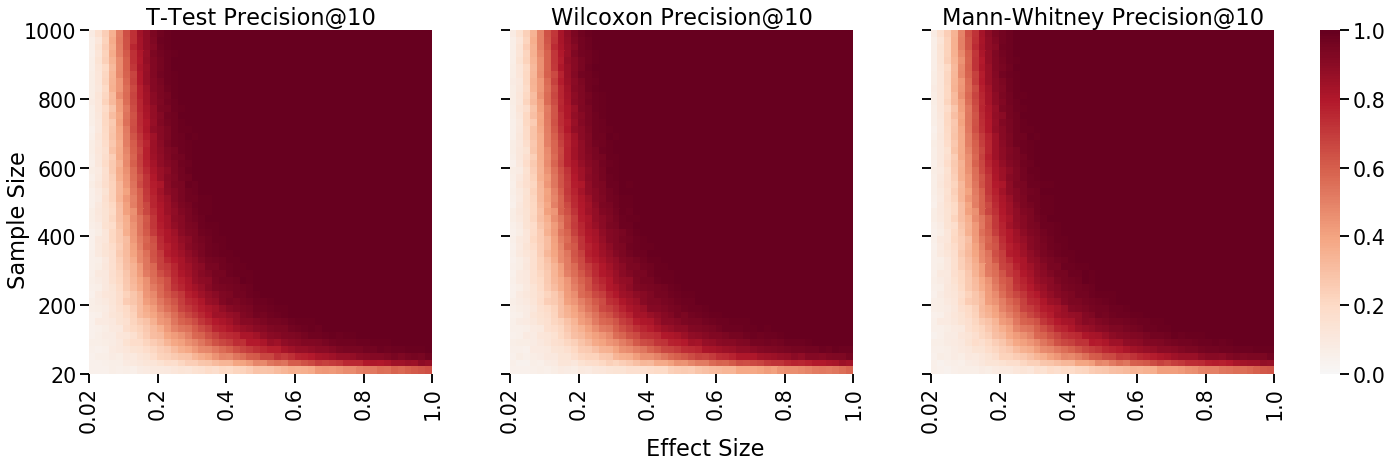

<IPython.core.display.Javascript object>

In [15]:
size = np.sqrt(res_df.shape[0]).astype(int)

ttest_prec = np.flipud(res_df.ttest_ind_precision_at_10.values.reshape(-1, size))
wilcoxon_prec = np.flipud(res_df.wilcoxon_precision_at_10.values.reshape(-1, size))
mannwhitney_prec = np.flipud(
    res_df.mannwhitneyu_precision_at_10.values.reshape(-1, size)
)

vmin = 0
vmax = 1

p = 0.5
spacing = 50
deltas = np.linspace(0, 1, spacing + 1)[::10]
deltas[0] += 0.02
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20

fmt = lambda x: "{:.2f}".format(x)
ms = ["{:.0f}".format(m) for m in ms][::-1]

with sns.plotting_context("talk", font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(19, 6),
        constrained_layout=True,
    )

    sns.heatmap(
        ttest_prec,
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        yticklabels=ms,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10))
    ax[0].set_title("T-Test Precision@10")

    sns.heatmap(
        wilcoxon_prec,
        ax=ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("Wilcoxon Precision@10")

    sns.heatmap(
        mannwhitney_prec,
        ax=ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Mann-Whitney Precision@10")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Effect Size", va="center", ha="center")

    fig.savefig(
        "./figures/20200204_diff_means_precision.png", dpi=300, bbox_inches="tight"
    )
    fig.savefig(
        "./figures/20200204_diff_means_precision.pdf", dpi=300, bbox_inches="tight"
    )

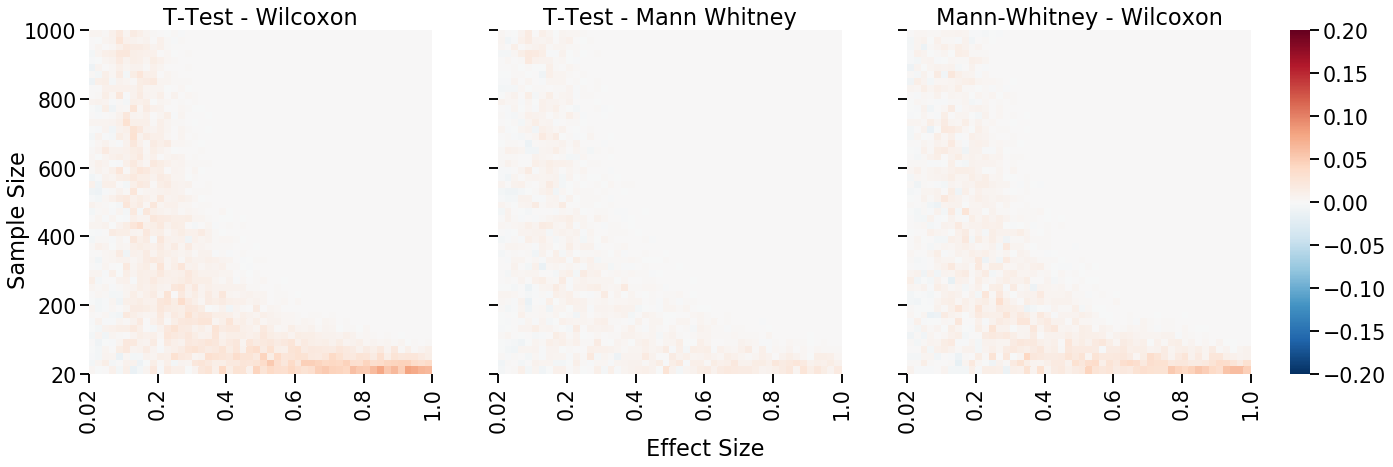

<IPython.core.display.Javascript object>

In [16]:
vmin = -0.2
vmax = 0.2

with sns.plotting_context("talk", font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(19, 6),
        constrained_layout=True,
    )

    sns.heatmap(
        ttest_prec - wilcoxon_prec,
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        yticklabels=ms,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
    ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10))
    ax[0].set_title("T-Test - Wilcoxon")

    sns.heatmap(
        ttest_prec - mannwhitney_prec,
        ax=ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("T-Test - Mann Whitney")

    sns.heatmap(
        mannwhitney_prec - wilcoxon_prec,
        ax=ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=deltas,
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax,
    )
    ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1] + 1, 10))
    ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0] + 1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Mann-Whitney - Wilcoxon")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Effect Size", va="center", ha="center")

    fig.savefig(
        "./figures/20200204_diff_means_diff_precision.png", dpi=300, bbox_inches="tight"
    )
    fig.savefig(
        "./figures/20200204_diff_means_diff_precision.pdf", dpi=300, bbox_inches="tight"
    )